# 门控循环单元（GRU）



In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

初始化模型参数

| 门控                       | 参数   | 变量名    | 形状                           | 作用          |
| ------------------------ | ---- | ------ | ---------------------------- | ----------- |
| **更新门**<br>(Update Gate) | 输入权重 | `W_xz` | `(vocab_size, num_hiddens)`  | 控制多少旧信息被保留  |
|                          | 隐藏权重 | `W_hz` | `(num_hiddens, num_hiddens)` |             |
|                          | 偏置   | `b_z`  | `(num_hiddens,)`             |             |
| **重置门**<br>(Reset Gate)  | 输入权重 | `W_xr` | `(vocab_size, num_hiddens)`  | 控制多少过去信息被遗忘 |
|                          | 隐藏权重 | `W_hr` | `(num_hiddens, num_hiddens)` |             |
|                          | 偏置   | `b_r`  | `(num_hiddens,)`             |             |
| **候选隐藏状态**               | 输入权重 | `W_xh` | `(vocab_size, num_hiddens)`  | 生成新的候选记忆    |
|                          | 隐藏权重 | `W_hh` | `(num_hiddens, num_hiddens)` |             |
|                          | 偏置   | `b_h`  | `(num_hiddens,)`             |             |


In [2]:
'''
vocab_size: 词汇表大小（决定输入/输出维度）
num_hiddens: 隐藏状态的维度（自定义的模型容量）
device: 计算设备（CPU或GPU）
'''
def get_params(vocab_size, num_hiddens, device):
    # 语言模型中：输入是词索引的one-hot向量，输出是下一个词的概率分布，维度都等于词汇表大小
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        # 生成均值为0、标准差为0.01的正态分布随机数
        # 符合Xavier/Glorot初始化思想，防止梯度消失/爆炸
        return torch.randn(size=shape, device=device)*0.01

    def three():
        '''
        three()一次性生成三组参数：
        输入→隐藏权重矩阵：(输入维度, 隐藏维度)
        隐藏→隐藏权重矩阵：(隐藏维度, 隐藏维度)
        偏置向量：全零向量，长度为隐藏维度
        '''
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three() # 更新门参数
    W_xr, W_hr, b_r = three() # 更新门参数
    W_xh, W_hh, b_h = three() # 候选隐状态参数
    # 将最后一个时间步的隐藏状态映射到输出空间;输出维度=词汇表大小，用于计算每个词的概率
    W_hq = normal((num_hiddens, num_outputs)) # 形状: (隐藏维度,词汇表大小)
    b_q = torch.zeros(num_outputs, device=device) # 形状: (词汇表大小,)
    # 将所有参数加入列表，便于后续统一更新
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True) # 允许自动求导
    return params

定义隐状态的初始化函数

In [3]:
'''
batch_size: 序列的批量大小（一次处理多少个样本）
num_hiddens: 隐藏状态的维度（每个样本的隐藏向量长度）
device: 设备（CPU/GPU）
'''
def init_gru_state(batch_size, num_hiddens, device):
    # 创建全零张量，形状为 (批量大小, 隐藏维度)
    return (torch.zeros((batch_size, num_hiddens), 
                        device=device), )# 显式指定设备，确保状态与模型在同一设备上，避免运行时错误
'''
返回格式 (tensor, )
注意末尾的逗号：这是Python中单元素元组的定义方式
为什么用元组？：
统一接口：与LSTM的 (hidden_state, cell_state) 格式保持一致
便于后续循环：在训练/预测时可直接用 state = init_gru_state(...) 然后传给GRU函数
解包方便：在GRU计算函数中可以用 H, = state 的方式解包获取隐藏状态
'''

定义门控循环单元模型

对于给定的时间步t，假设输入是一个小批量$X_{t} \in \mathbb{R}^{n\times d}$（样本个数n，输入个数d），上一个时间步的隐状态是$H_{t-1} \in \mathbb{R}^{n\times h}$（隐藏单元个数h）。那么，重置门$R_{t} \in \mathbb{R}^{n\times h}$和更新门$Z_{t} \in \mathbb{R}^{n\times h}$的计算如下所示：<br>
$R_{t}=\sigma (X_{t}W_{xr}+H_{t-1}W_{hr}+b_{r})$,<br>
$Z_{t}=\sigma (X_{t}W_{xz}+H_{t-1}W_{hz}+b_{z})$<br>
其中$W_{xr}$,$W_{xz} \in \mathbb{R}^{d \times h}$和$W_{hr}$,$W_{hz} \in \mathbb{R}^{h \times h}$是权重参数，$b_{r}$,$b_{z} \in \mathbb{R}^{1 \times h}$是偏置参数。请注意，在求和过程中会触发广播机制（请参阅 2.1.3节）。我们使用sigmoid函数（如4.1节中介绍的）将输入值转换到区间(0,1)。

接下来，让我们将重置门与(8.4.5)中的常规隐状态更新机制集成，得到在时间步的候选隐状态（candidate hidden state）$\tilde{H_{t}} \in \mathbb{R}^{n\times h}$。<br>
$\tilde{H}_{t}=tanh(X_{t}W_{xh}+(R_{t}\odot H_{t-1})W_{hh}+b_{h})  $<br>
其中$W_{xh} \in \mathbb{R}^{d \times h}$和$W_{hh} \in \mathbb{R}^{h \times h}$是权重参数，$b_{h} \in \mathbb{R}^{1 \times h}$是偏置项，$\odot$符号是Hadamard积（按元素乘积）运算符。在这里，我们使用tanh非线性激活函数来确保候选隐状态中的值保持在区间(-1,1)中。<br>
与(8.4.5)相比，(9.1.2)中的$R_{t}$和$H_{t-1}$的元素相乘可以减少以往状态的影响。每当重置门$R_{t}$中的项接近1时，我们恢复一个如(8.4.5)中的普通的循环神经网络。对于重置门$R_{t}$中所有接近0的项，候选隐状态是以$X_{t}$作为输入的多层感知机的结果。因此，任何预先存在的隐状态都会被重置为默认值。图9.1.2说明了应用重置门之后的计算流程。<br>
![](./img/在门控循环单元模型中计算候选隐状态.png)

上述的计算结果只是候选隐状态，我们仍然需要结合更新门$Z_{t}$的效果。这一步确定新的隐状态$H_{t} \in \mathbb R^{n \times h}$在多大程度上来自旧的状态$H_{t-1}$和新的候选状态$\tilde{H}_{t}$。更新门$Z_{t}$仅需要在$H_{t-1}$和$\tilde{H}_{t}$之间进行按元素的凸组合就可以实现这个目标。这就得出了门控循环单元的最终更新公式：<br>
$H_{t}=Z_{t}\odot H_{t-1}+(1-Z_{t})\odot \tilde {H}_{t}$<br>
每当更新门$Z_{t}$接近1时，模型就倾向只保留旧状态。此时，来自$X_{t}$的信息基本上被忽略，从而有效地跳过了依赖链条中的时间步t。 相反，当$Z_{t}$接近0时，新的隐状态$H_{t}$就会接近候选隐状态$\tilde{H}_{t}$。这些设计可以帮助我们处理循环神经网络中的梯度消失问题，并更好地捕获时间步距离很长的序列的依赖关系。例如，如果整个子序列的所有时间步的更新门都接近于1，则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。<br>
![](./img/计算门控循环单元模型中的隐状态.png)


In [4]:
'''
输入X_t → [更新门Z] → 控制保留旧信息
      ↘ [重置门R] → 控制遗忘旧信息
      ↘ [候选状态H̃] → 生成新记忆
      ↘ [融合] → H_t = Z·H_{t-1} + (1-Z)·H̃_t
      ↘ [输出层] → Y_t
inputs: 输入序列（形状: 时间步数, 批量大小, 词表维度）
state: 初始隐藏状态（元组形式，含初始H_0）
params: 11个可训练参数列表（来自get_params()函数）
'''
def gru(inputs, state, params):
    # 从列表中按顺序解包所有权重和偏置;H是当前时间步的隐藏状态（初始为H_0）
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # 循环次数=序列长度，每次处理一个时间步X（形状:批量大小,词表维度）
    for X in inputs: # 遍历每个时间步的输入
        '''
        1. 更新门（Update Gate）
        决定保留多少旧信息（Ht−1）和接受多少新信息;输出范围：[0,1]，形状:(批量大小,隐藏维度)
        '''
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        '''
        2. 重置门（Reset Gate）:控制多少过去信息被遗忘;输出范围：[0,1]
        '''
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        '''
        3. 候选隐藏状态（Candidate Memory）
        R*H：重置后的隐藏状态（Hadamard积）,生成新的候选记忆，范围[-1,1]
        '''
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        '''
        隐藏状态更新
        Z⊙Ht−1:保留的旧信息
        (1−Z)⊙ Ht~:接受的新信息
        '''
        H = Z * H + (1 - Z) * H_tilda
        '''
        输出计算
        将当前隐藏状态映射到输出空间（如词表概率分布）;每个时间步的Y形状: (批量大小, 词表大小)
        '''
        Y = H @ W_hq + b_q
        outputs.append(Y)
    '''
    torch.cat(outputs, dim=0):将所有时间步输出拼接为一个大张量
    形状:(时间步数×批量大小,词表大小)，便于后续计算交叉熵损失
    (H,):最终隐藏状态（元组形式，与输入state格式一致）
    '''
    return torch.cat(outputs, dim=0), (H,)

训练

perplexity 1.1, 13159.0 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


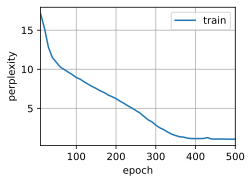

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

简洁实现

perplexity 1.0, 135126.0 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


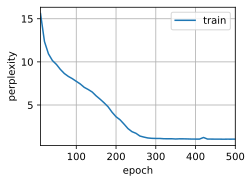

In [6]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)